In [1]:
import os
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Initializing the Azure OpenAI LLM
llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME_LLM"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION_LLM"],
)

In [3]:
# Initializing the Azure OpenAI Embedding
embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME_EMBEDDING"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION_EMBEDDING"],
)

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

We’ll build an app that answers questions about the website's content. The specific website we will use is the [LLM Powered Autonomous Agents blog post](https://lilianweng.github.io/posts/2023-06-23-agent/) by Lilian Weng, which allows us to ask questions about the contents of the post.

In [5]:
# We can create a simple indexing pipeline and RAG chain to do this in ~50 lines of code.

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            # Only parse the main content of the blog.
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# This will printing vector store.
print(_)

['93cdddd4-28e6-4427-b823-cf5f6698a89c', '811d30e0-c991-446b-8fe0-041c8846789e', '336327c0-19b1-4e0f-a768-c6a65d398952', 'f49687a3-856d-4a04-a736-870ee82a00cc', 'ac4ba4a4-7afb-4f53-bf11-269f683db291', '97292a49-6b1f-467a-a2c3-0514e02879e7', '819c435b-2c96-43a8-9e56-3ab9b00a4ab1', 'aff61713-346c-4dc5-bb1b-418fc03bbb7a', '558b48c5-3dfa-4a72-b99b-1caed1391142', 'dc361d2a-a710-4eb5-97b5-490ad142b564', '3bb65e65-ca24-416c-86e0-98a2f029c60f', '2cd3e60d-867a-403d-b085-110f2ce41009', 'b6887319-2dfd-4922-bc83-95b5b88819ea', 'b632e7ab-2cba-4ce9-8073-2c355b894de5', '85d01494-5cba-4d31-a763-0a592e30c9c8', '08b8f593-6bfe-40d9-9626-74772c1051ac', '048246be-81c8-4cf5-9184-e43534f42a9c', '4e18961d-eec0-40c6-97cb-9ea3b94e50b0', '5ebc7622-e665-4b7e-af9d-0b3dc063b242', '289884f7-ea9d-400e-8ded-49f300c197fc', 'eb7ff36b-581a-442e-a54c-c8ed49e4bb40', '12099733-dbc3-4028-a732-dde996ce5b23', '47721641-257c-476b-a891-4356282e01ca', 'b3ebe6aa-0c0c-4715-9a60-cb016ef56337', '3c5d1fb8-56a8-4f90-a182-5cf0c344df84',

In [8]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition involves breaking down a complex task into smaller, manageable steps to facilitate easier execution and understanding. This process can be accomplished using various methods, including prompting by language models, task-specific instructions, or human inputs. It aims to simplify difficult tasks by creating subgoals that can be addressed sequentially.


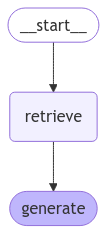

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Advanced RAG

#### 1. Indexing

In [10]:
# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [11]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [12]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


#### 2. Retrieval and Generation

In [13]:
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [14]:
# Query analysis

total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [15]:
# Reinitialize the vector store
vector_store = InMemoryVectorStore(embeddings)

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['514cfa4e-428d-4d12-8adc-7b5d59d199d4', '6d0f6025-3961-472c-9d01-edd077d97481', '47e3ce79-c1b0-4181-aad2-e73c105d5340']


In [16]:
# Let's next define a schema for our search query

from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

##### Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [17]:
class State(TypedDict):
    question: str
    query: Search # Search query
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [18]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='249ea319-1cbe-4d5a-86f5-8f9b34c2c1a8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32069, 'section': 'end'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide mor

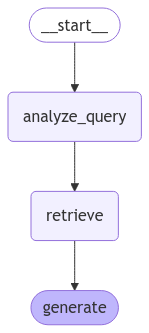

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Chains

In [20]:
# Reinitialize the vector store
vector_store = InMemoryVectorStore(embeddings)

# Reinitialize the text splitter
all_splits = text_splitter.split_documents(docs)

_ = vector_store.add_documents(documents=all_splits)

Conversational experiences can be naturally represented using a sequence of messages. In addition to messages from the user and assistant, retrieved documents and other artifacts can be incorporated into a message sequence via tool messages.

In [21]:
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)

In [22]:
# Let's turn our retrieval step into a tool
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
2. A node for the retriever tool that executes the retrieval step;
3. A node that generates the final response using the retrieved context.

We build them below. Note that we leverage another pre-built LangGraph component, [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode), that executes the tool and adds the result as a ToolMessage to the state.

In [23]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Finally, we compile our application into a single graph object. In this case, we are just connecting the steps into a sequence. We also allow the first query_or_respond step to "short-circuit" and respond directly to the user if it does not generate a tool call. This allows our application to support conversational experiences-- e.g., responding to generic greetings that may not require a retrieval step

In [24]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

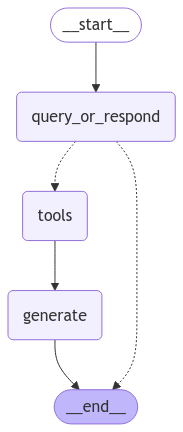

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application.

In [26]:
# Application responds appropriately to messages that do not require an additional retrieval step:

input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [27]:
# executing a search, we can stream the steps to observe the query generation, retrieval, and answer generation:

input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_nTEg6QThnTBcXX4Gz1WJLIXb)
 Call ID: call_nTEg6QThnTBcXX4Gz1WJLIXb
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Ste

## Stateful management of chat history

In [28]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [29]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_2IzjECtk5CrECFRWOsnSq2vg)
 Call ID: call_2IzjECtk5CrECFRWOsnSq2vg
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XY

In [30]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_koYekmCgEMKRSkkfKsifZNv6)
 Call ID: call_koYekmCgEMKRSkkfKsifZNv6
  Args:
    query: common methods for task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM wit

Note that the query generated by the model in the second question incorporates the conversational context.

## Agents

In [31]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

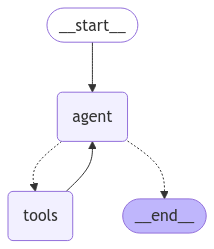

In [32]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_oYLNgFn3JxHpL3BFWShKeuoI)
 Call ID: call_oYLNgFn3JxHpL3BFWShKeuoI
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (vi

Note that the agent:

1. Generates a query to search for a standard method for task decomposition;
2. Receiving the answer, generates a second query to search for common extensions of it;
3. Having received all necessary context, answers the question.

## RAG for PDF Document using PyPDFLoader

In [34]:
# 1.Initializing the PyPDFLoader

from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(
    "Human-Centered_AI_in_Smart_Farming_Toward_Agriculture_5.0.pdf",
)

In [35]:
# 2. Loading the PDF document

docs = loader.load()
docs[0]

Document(metadata={'source': 'Human-Centered_AI_in_Smart_Farming_Toward_Agriculture_5.0.pdf', 'page': 0, 'page_label': '62199'}, page_content='Received 11 April 2024, accepted 28 April 2024, date of publication 30 April 2024, date of current version 8 May 2024.\nDigital Object Identifier 10.1 109/ACCESS.2024.3395532\nHuman-Centered AI in Smart Farming:\nToward Agriculture 5.0\nANDREAS HOLZINGER\n 1,3,4, (Senior Member, IEEE), IZTOK FISTER JR.\n1,2, (Member, IEEE),\nIZTOK FISTER SR.2, (Member, IEEE), HANS-PETER KAUL\n5,\nAND SENTHOLD ASSENG6, (Member, IEEE)\n1Human-Centered AI Laboratory, Department of Forest- and Soil Sciences, University of Natural Resources and Life Sciences Vienna, 1190 Vienna, Austria\n2Faculty of Electrical Engineering and Computer Science, University of Maribor, 2000 Maribor, Slovenia\n3Human-Centered AI Laboratory, Department for Agrobiotechnology, University of Natural Resources and Life Sciences Vienna, 3430 Tulln, Austria\n4xAI Laboratory, Alberta Machine Int

In [36]:
# Page content and metadata of the document

print(docs[0].page_content[:200])

print(docs[0].metadata)

Received 11 April 2024, accepted 28 April 2024, date of publication 30 April 2024, date of current version 8 May 2024.
Digital Object Identifier 10.1 109/ACCESS.2024.3395532
Human-Centered AI in Smart
{'source': 'Human-Centered_AI_in_Smart_Farming_Toward_Agriculture_5.0.pdf', 'page': 0, 'page_label': '62199'}


In [37]:
# 3. Splitting the document into chunks

# Reinitialize the text splitter
all_splits = text_splitter.split_documents(docs)

len(all_splits)

130

In [38]:
# 4. Vector Store & Embedding

# Reinitialize the vector store
vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_documents(documents=all_splits)

In [39]:
print(_)

['ef6130e5-3815-4a7c-9550-e4c73b28668f', '6a70e1d0-7fea-4952-a41c-904eb3853010', '1ef8686e-ca26-45f5-bbfa-96b0d0390f70', '7e2bb49f-2d8a-44e0-afed-4b538d2244f8', 'fcc14105-b29a-49f2-9c5f-4de57d4c98e0', '446c123d-3176-4c58-b7d2-75a87be74e63', '0583d3fa-feee-4938-81b4-21d97ae58b8f', '18e4bd77-77c1-4058-b1b7-80ec6f912b6d', 'e77a947a-632c-4616-99c6-496cdc32ab2b', 'f32ee2c9-1205-4f2b-aa68-a7794f1f6108', '9d93182f-59fb-4e21-9ef2-3f5556146178', '41a4a2a3-3dc3-4bf1-9923-dd77dade07a5', '8a4658f6-cd8c-4806-b52c-eed56947e2a3', 'f4ee8d3d-d3f5-4b95-879e-a0209c9b90d1', '5b0c8127-bcc0-455d-95e2-fcbaebe51ddb', 'cdc56d5f-103a-403b-bdf3-cb76e763a847', '54d9ba84-f7e0-434e-a10d-8512475b32de', '5f2af011-262d-42d2-89cc-3818e00294eb', 'b527d6f7-03d2-474d-b7b3-606345937d15', 'b9ce15c1-d548-4b8c-a250-62afc7d49afe', '0be6017d-df4b-4a77-bf11-a4383acb9aab', 'aad2707b-89d1-43c5-b381-0db14b0a4b27', '34105956-b08b-4e4d-8823-cb837b94df8e', '51e6205a-c310-47ff-bab4-c6c516933fb3', 'ade85b3c-6b2b-49dd-89cd-d3ef5f882961',

In [40]:
# 5. Performing RAG on the PDF document utilizing the previously built agent pipeline

config= {"configurable": {"thread_id": "def345"}}
input_message = (
    "Mention the title of the document we are using\n\n"
    "Get the summary of the same document"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Mention the title of the document we are using

Get the summary of the same document
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_z78X6ctzusCghQ7sXxVmI7Ay)
 Call ID: call_z78X6ctzusCghQ7sXxVmI7Ay
  Args:
    query: title of the document
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'Human-Centered_AI_in_Smart_Farming_Toward_Agriculture_5.0.pdf', 'page': 0, 'page_label': '62199', 'start_index': 4272}
Content: 2024 The Authors. This work is licensed under a Creative Commons Attribution 4.0 License.
For more information, see https://creativecommons.org/licenses/by/4.0/ 62199

Source: {'source': 'Human-Centered_AI_in_Smart_Farming_Toward_Agriculture_5.0.pdf', 'page': 0, 'page_label': '62199', 'start_index': 3294}
Content: INDEX TERMS Human-centered AI, smart farming, agricultu